In [12]:
import pickle
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_auc_score,
    roc_curve,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)


In [13]:
def load_models(models_path='../models/'):
    models = {}
    for filename in os.listdir(models_path):
        if filename.endswith('.pkl') and filename not in ['scaler.pkl', 'test_data.pkl']:
            if 'xgboost' in filename.lower():
                print("Skipping XGBoost model due to loading issues")
                continue
            model_name = filename.replace('.pkl', '').replace('_', ' ').title()
            with open(os.path.join(models_path, filename), 'rb') as f:
                models[model_name] = pickle.load(f)
    return models


def load_test_data(models_path='../models/'):
    """Load test data and scaler"""
    with open(os.path.join(models_path, 'test_data.pkl'), 'rb') as f:
        X_test, y_test = pickle.load(f)
    with open(os.path.join(models_path, 'scaler.pkl'), 'rb') as f:
        scaler = pickle.load(f)
    return X_test, y_test, scaler

# Load models and test data
models = load_models()
X_test, y_test, scaler = load_test_data()

print(f"✅ Loaded {len(models)} models")
print(f"✅ Test set size: {X_test.shape}")
print(f"✅ Models: {list(models.keys())}")


Skipping XGBoost model due to loading issues
✅ Loaded 3 models
✅ Test set size: (56962, 30)
✅ Models: ['Decision Tree', 'Logistic Regression', 'Random Forest']


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.7.2 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.7.2 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.7.2 when using version 1.5.1. This

In [14]:
def evaluate_model(model, X_test, y_test):
    """Evaluate model and return metrics"""
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)
    cm = confusion_matrix(y_test, y_pred)
    
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'confusion_matrix': cm,
        'fpr': fpr,
        'tpr': tpr,
        'y_pred': y_pred,
        'y_proba': y_proba
    }

# Evaluate all models
results = {}
for name, model in models.items():
    print(f"Evaluating {name}...")
    results[name] = evaluate_model(model, X_test, y_test)
    
print("\n✅ All models evaluated!")


Evaluating Decision Tree...
Evaluating Logistic Regression...
Evaluating Random Forest...

✅ All models evaluated!


In [15]:
# Create comparison dataframe
comparison_data = []
for name, result in results.items():
    comparison_data.append({
        'Model': name,
        'Accuracy': result['accuracy'],
        'Precision': result['precision'],
        'Recall': result['recall'],
        'F1-Score': result['f1'],
        'ROC-AUC': result['roc_auc']
    })

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values('ROC-AUC', ascending=False)

# Display with styling
comparison_df.style.background_gradient(cmap='YlGn', subset=['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC'])


,Model,Accuracy,Precision,Recall,F1-Score,ROC-AUC
2,Random Forest,0.999456,0.845361,0.836735,0.841026,0.973103
1,Logistic Regression,0.974211,0.058027,0.918367,0.109157,0.969863
0,Decision Tree,0.983673,0.079798,0.806122,0.145221,0.895084


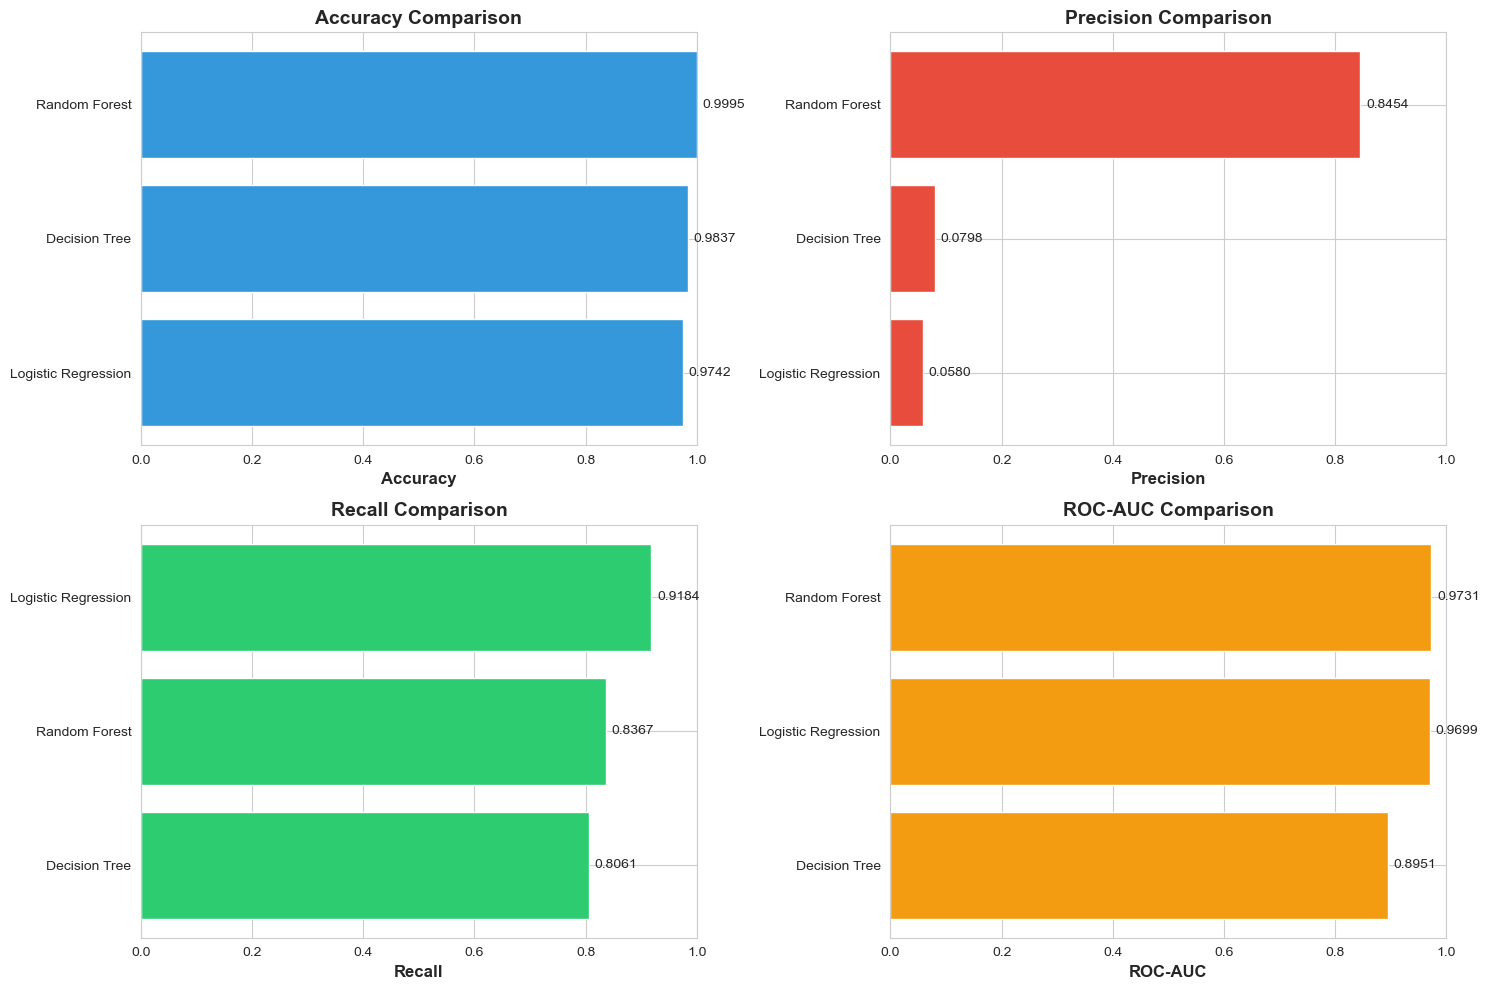

In [16]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

metrics = ['Accuracy', 'Precision', 'Recall', 'ROC-AUC']
colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12']

for idx, metric in enumerate(metrics):
    ax = axes[idx // 2, idx % 2]
    data = comparison_df.sort_values(metric, ascending=True)
    ax.barh(data['Model'], data[metric], color=colors[idx])
    ax.set_xlabel(metric, fontsize=12, fontweight='bold')
    ax.set_title(f'{metric} Comparison', fontsize=14, fontweight='bold')
    ax.set_xlim(0, 1.0)
    
    # Add value labels
    for i, v in enumerate(data[metric]):
        ax.text(v + 0.01, i, f'{v:.4f}', va='center')

plt.tight_layout()
plt.show()


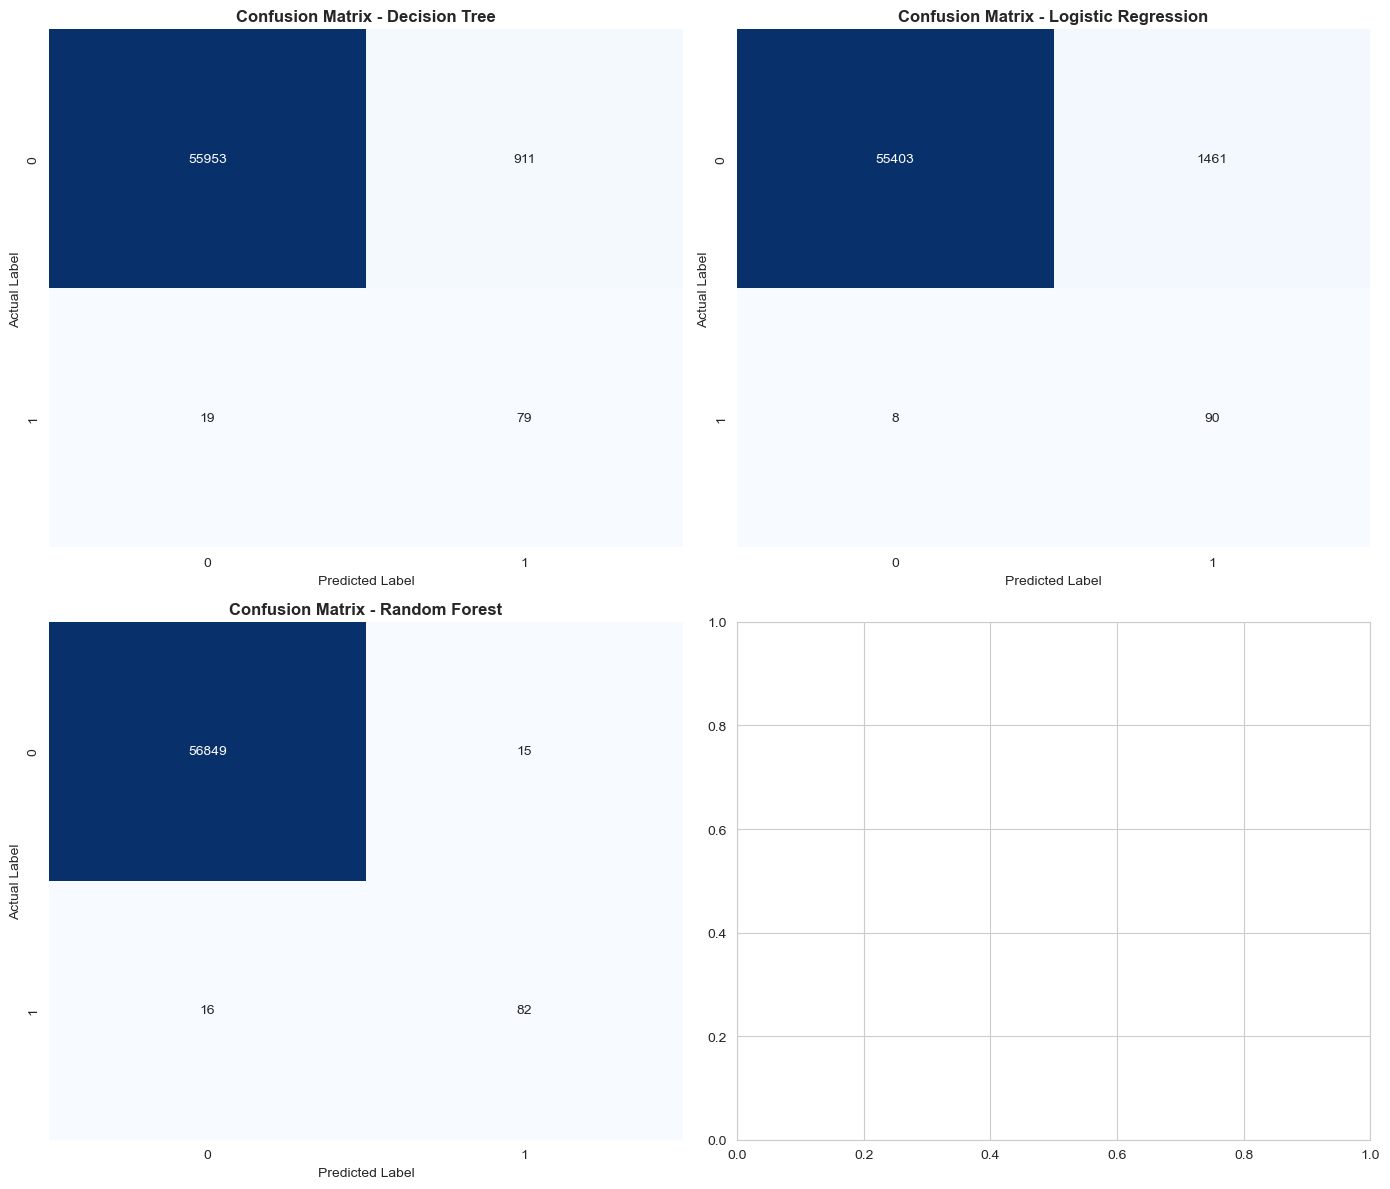

In [17]:
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.ravel()

for idx, (name, result) in enumerate(results.items()):
    if idx < len(axes):
        sns.heatmap(result['confusion_matrix'], annot=True, fmt='d', cmap='Blues', ax=axes[idx], cbar=False)
        axes[idx].set_title(f'Confusion Matrix - {name}', fontsize=12, fontweight='bold')
        axes[idx].set_ylabel('Actual Label')
        axes[idx].set_xlabel('Predicted Label')

plt.tight_layout()
plt.show()


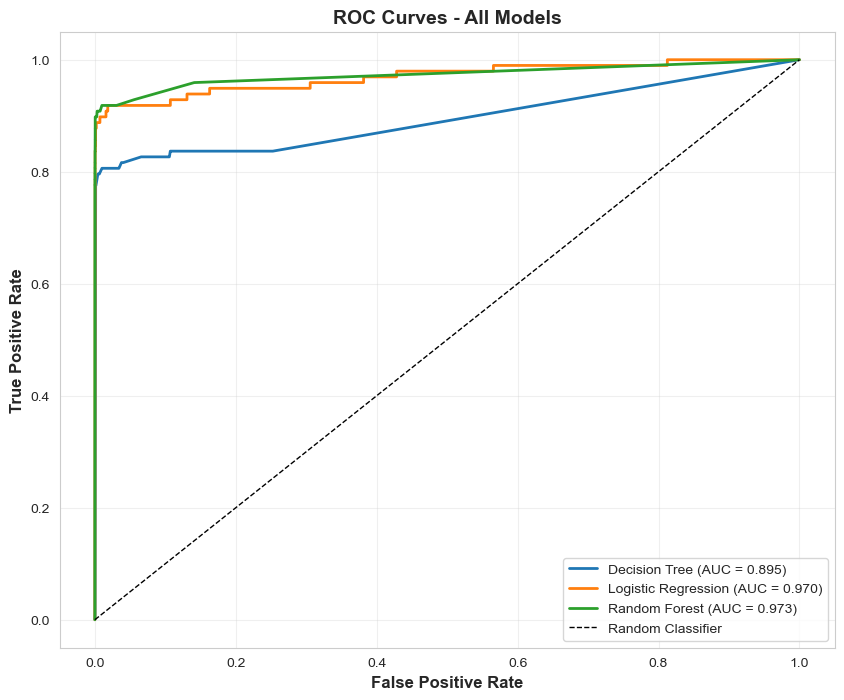

In [18]:
plt.figure(figsize=(10, 8))

for name, result in results.items():
    plt.plot(result['fpr'], result['tpr'], label=f"{name} (AUC = {result['roc_auc']:.3f})", linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1)
plt.xlabel('False Positive Rate', fontsize=12, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=12, fontweight='bold')
plt.title('ROC Curves - All Models', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=10)
plt.grid(alpha=0.3)
plt.show()


In [19]:
for name, result in results.items():
    print(f"\n{'='*70}")
    print(f"Classification Report - {name}")
    print(f"{'='*70}")
    print(classification_report(y_test, result['y_pred'], target_names=['Legitimate', 'Fraud']))



Classification Report - Decision Tree
              precision    recall  f1-score   support

  Legitimate       1.00      0.98      0.99     56864
       Fraud       0.08      0.81      0.15        98

    accuracy                           0.98     56962
   macro avg       0.54      0.90      0.57     56962
weighted avg       1.00      0.98      0.99     56962


Classification Report - Logistic Regression
              precision    recall  f1-score   support

  Legitimate       1.00      0.97      0.99     56864
       Fraud       0.06      0.92      0.11        98

    accuracy                           0.97     56962
   macro avg       0.53      0.95      0.55     56962
weighted avg       1.00      0.97      0.99     56962


Classification Report - Random Forest
              precision    recall  f1-score   support

  Legitimate       1.00      1.00      1.00     56864
       Fraud       0.85      0.84      0.84        98

    accuracy                           1.00     56962
   ma

In [20]:
best_model_name = comparison_df.iloc[0]['Model']
best_auc = comparison_df.iloc[0]['ROC-AUC']

print(f"\n{'='*70}")
print(f"🏆 BEST MODEL: {best_model_name}")
print(f"{'='*70}")
print(f"ROC-AUC Score: {best_auc:.4f}")
print(f"\nThis model shows the best overall performance for fraud detection.")
print(f"Consider this model for deployment or further tuning.")



🏆 BEST MODEL: Random Forest
ROC-AUC Score: 0.9731

This model shows the best overall performance for fraud detection.
Consider this model for deployment or further tuning.
